In [3]:
import numpy as np
import scipy
import math
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table
from astropy.constants import h, c
%matplotlib inline


In [4]:
def mag2flux(mag, zero_pt=21.1, ABwave=None):
    if ABwave != None:
        return 10.**(-0.4*(mag+2.406+5*np.log10(ABwave)))
    return 10.**(-0.4*(mag+zero_pt))

In [14]:
def planck(wave, temp):
    w=wave/1e8
    c1 =  3.7417749e-5  #=2*!DPI*h*c*c   
    c2 = 1.4387687    # =h*c/k
    val=c2/w/temp
    bbflux=c1/(w**5 * (math.e**val-1))*1e-8
    return bbflux
#print(planck(4000, 1000))
print(range(5))

range(0, 5)


In [ ]:
def gen_cal(wave, cdir, calname):
    calfile=cdir+calname
    lwave=calfile['col1']
    lflux=calfile['col2']
    caldata=scipy.interpolate.spline(lflux, lwave, wave)
    nline=len(lwave)
    nwave=len(wave)
    flux_out=wave*0.
    for i in range(nline):
        if (lwave[i] < wave[0]) or (lwave[i] > wave[-1]):
            continue
        diff=np.absolute(wave-lwave[i])
        sort_idx=np.sort(diff)
        adjwave=wave[sort_idx]

In [5]:
def flux2bpmag(flam, wave, filtertrans_input, filterwave=None,
               errflag=None, flam_err=None, bpmag_err=None):
    mintrans=0.0001
    filtertrans=filtertrans_input
    if filterwave != None:
        #filtertrans=interpol(filtertrans, filterwave, wave)
        filtertrans=scipy.interpolate.spline(filterwave, filtertrans, wave)
    filtertrans=(filtertrans >= mintrans)*filtertrans
    
    nwave=len(wave)
    if len(filtertrans) != nwave:
        errflag=1
        return
    
    constc=scipy.constants.c
    filtertrans=filtertrans.astype(double)
    flux=np.sum(flam*filtertrans)
#       refflam=replicate(3631.d-23, nwave)/wave^2.*!const.c*1.d10
    #refflam=replicate(3631.d-23, nwave)/wave^2.*constc*1.d10
    
    refflam=np.ones(nwave)*3631e-23/wave^2.*constc*1e10
    
    refflux=np.sum(refflam*filtertrans)
    if flam_err != None:
        err=(np.sum((flam_err*filtertrans)^2))^0.5
        bpmag_err=-2.5/np.log(10)/flux*err
    bpmag=-2.5*np.log10(flux/refflux)
    return bpmag
 

In [6]:
def return_flux(source, wave, magnitude, band, z, exptime, wstep, cdir, 
                bbtemp,
                temptitle=None):
 #Identify source type
    consth=scipy.constants.h
    constc=scipy.constants.c
    src_check=source.split('_')
    src_type=src_check[0]
    if len(src_check) == 2:
        src_value=src_check[1]
        
    nwave=len(wave)

    if src_type =='const':
        magarr=np.ones(nwave)*magnitude
        photone=consth*1e7*constc/(wave*1e-10)
        sourceflux=mag2flux(magnitude, ABwave=wave)
        temptitle='Constant Magnitude of'
        #constflux=replicate(sourceflux[n_elements(sourceflux)/2], nwave)
        #sourceflux=constflux
    
    if src_type =='gal':
        galtemptile=cdir+'kc96/'+src_value+'_template.ascii'
        galfile=ascii.read(galtempname, data_start=0)
        galflam=galfile['col1']/(1.+z)
        galwave=galfile['col2']*(1.+z)
        galflux=scipy.interpolate.spline(galflam, galwave, wave) 
        bpmag=flux2bpmag(galflux, wave, band)
        ratio=10.^(-0.4*(magnitude-bpmag))
        sourceflux=ratio*galflux
        temptitle='Type Galaxy'
    
#    if src_type =='skyflat':

    if src_type =='arcflat':
        arcfile=cdir+'Xenon_lamp.txt'
        , format='D,D', xwave, xflam
        xwave=arcfile['col1']
        xflam=arcfile['col2']
        sourceflux=scipy.interpolate.spline(xflam, xwave, wave)*10.^(-12.)
        sourceflux=sourceflux*((wave ge min(xwave)) and (wave le max(xwave)))
        temptitle='Xenon Arc Lamp'

    if src_type =='blackbody':
        sourceflux=planck(wave, bbtemp)*0.015^2.*!pi/(1e5)^2

    if src_type =='wavecal':
        
    
    
    
    
    
    return sourceflux

IndentationError: expected an indented block (<ipython-input-6-8185e8bc9b47>, line 23)

In [8]:
        bandname='/home/hchung/dotifs/py_etc/rfilter.dat'
        bandfile=ascii.read(bandname, data_start=2)
        #band=scipy.interpolate.spline(bandfile['wavenm'],
         #                                 bandfile['t0'],
          #                                waveang)
       # print(bandfile['col1'])

 col1 
------
5330.0
5340.0
5350.0
5360.0
5370.0
5380.0
5390.0
5400.0
5410.0
5420.0
   ...
7620.0
7630.0
7640.0
7650.0
7660.0
7670.0
7680.0
7690.0
7700.0
7710.0
7720.0
Length = 240 rows


/home/hchung/dotifs/py_etc/trans150626.dat
[0.832556 0.832556 0.832556 ... 0.832556 0.832556 0.832556]
[3452.15814162 3632.41363339 3812.79894316 ... 1605.41744645 1605.67469369
 1605.93194092] 1 / (J m)
[58.75506907 60.26950832 61.7478659  ... 40.06766086 40.07087089
 40.07408066] 1 / (J(1/2) m(1/2))


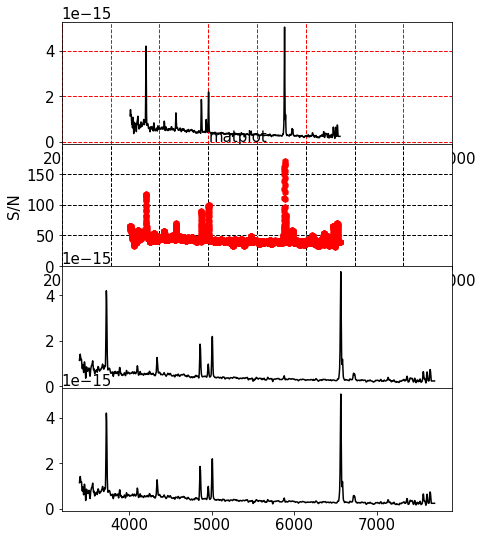

In [2]:
class dotifs_etc(object):
    def __init__(self, exptime=900, band='r', magnitude=17., 
                 oname='snr.ps', galtemp=False, z=None, inputflux=None, inputwave=None, 
                 bbtemp=False, wavecal=False, skyflat=False, arcflat=False,
                 source='gal_sc', bbtemp=5000, 
                 stype=0, skymagnitude=None, nofilter=False,
                 noplot=False, plotrange=[3700, 7400], wstep=(3700./3000), pixel=None, 
                 cspline=False, wavearr=None, scflag=True,
                 waveout=None, snrout=None, signalarr=None, skysignalarr=None, noisearr=None, noiseskyarr=None, 
                 dtypes=None, ofile='outdata.txt', 
                 pri=3.6, sec=0.915, skysamplingsize=0.4**2*math.pi, dispersion=3700/(3000*15), pixelsize=15,
                 cdir='/home/hchung/dotifs/py_etc/',
                ):
        use_asahi=1
        ltrghost=1
        consth=scipy.constants.h
        constc=scipy.constants.c
        
        
        telaream2=(pri**2-sec**2)/4*math.pi         #in m^2
        telarea=telaream2*1e4                           #in cm^2
        pixelscale=dispersion*pixelsize
        if pixel != None:
            wstep=pixel*pixelscale
        stwave=plotrange[0]
        edwave=plotrange[1]
        
        
        transfname=cdir+'trans150626.dat'
        #data=ascii.read(transfile, format='no_header')
        transfile=ascii.read(transfname, data_start=1)
        wavemicron=np.array(transfile['micron'])
        waveang=wavemicron*1e4
        skytrans=np.array(transfile['SkyTrans'])
        telmag=np.array(transfile['telandmag'])
        col=np.array(transfile['col'])
        cam=np.array(transfile['cam'])
        ccd=np.array(transfile['ccd'])
        g0th_o=np.array(transfile['0th'])
        g1st_o=np.array(transfile['1st'])
        g2nd_o=np.array(transfile['2nd'])
        
        vphfname=cdir+'vph_160307_new.dat'
        vphfile=ascii.read(vphfname, data_start=1)
        eff_vph_new=scipy.interpolate.spline(vphfile['wave_new'],
                                             vphfile['vph_trans'],
                                             waveang/10)
        
        coatfname=cdir+'altcoating.dat'
        coatfile=ascii.read(coatfname, data_start=1)
        eff_coat=scipy.interpolate.spline(coatfile['wavenm'],
                                          coatfile['t0'],
                                          waveang/10)/100        
        
        ccdfname=cdir+'ccd_multi2.txt'
        ccdfile=ascii.read(ccdfname, data_start=1)
        ccd=scipy.interpolate.spline(ccdfile['wave'],
                                     ccdfile['QE'],
                                     waveang/10)

        bandname=cdir+band+'filter.dat'
        bandfile=ascii.read(bandname, data_start=2)
        band=scipy.interpolate.spline(bandfile['col1'],
                                          bandfile['col2'],
                                          waveang)
        
        
        
        waveang=tfile['micron']*1e4
        
        if wavearr == None:
            nwave=int((waveang[-1]-waveang[0])/wstep)+1
            wave=np.linspace(0, nwave-1, num=nwave)*wstep+waveang[0]
        else:
            wave=np.array(wavearr)
            nwave=len(wavearr)


        sourceflux=return_flux(source, wave, magnitude, 
                               band, z, exptime, wstep, cdir)
        
        
        
        galtempfilename=cdir+'kc96/'+'sc'+'_template.fits'
  
        galtempfile=fits.open(galtempfilename, memmap=True)
     
        galtemp=Table(galtempfile[1].data)
        galflam=galtemp['FLUX']
        galwave=galtemp['WAVELENGTH']
        
        sourceflux=np.interp(wave,galwave,galflam)*1e-2
        

        
        
        transtemp=np.interp(wave,tfile['micron']*1000,tfile['cam'])
        print(transtemp)
                
        photone=h*1e7*c/(wave*1e-10)

        sourcecount=(sourceflux/photone)*wstep*telarea*exptime*skysamplingsize
        print(sourcecount)
        
        signal=sourcecount
        noise=signal**0.5
        
        snr=signal/noise
        print(snr)
        
        matplotlib.rcParams.update({'font.size':15})
        font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}

        matplotlib.rc('font', **font)
        
        plt.clf
        fig=plt.figure(figsize=(7,9))
        #gs1=matplotlib.gridspec.GridSpec(8,12)
        gs1=gridspec.GridSpec(4,1)
        gs1.tight_layout(fig, rect=[0,0,0.1,1])
        gs1.update(hspace=0)
        #gs1.tight_layout(fig, rect=[0,0,1,0.5])
        
        
        #ax=plt.subplot(211)
        ax0=plt.subplot(gs1[0])
        ax0.plot(wave, sourceflux, 'k', linestyle='-')
        plt.text(5000,0.00000001*0, 'matplot')
        #ax=plt.subplot(212)
        ax=plt.subplot(gs1[1])
        ax.plot(wave, snr, 'rh')
        #ax.set_ylabel("S/N", fontsize=20)
        #ax.set_xlabel("Wavelength $\AA$ ", fontsize=20)
        ax.set_ylabel("S/N")
        ax.set_xlabel("Wavelength ($\AA$) ")
        ax.grid(b=True, which='major', color='k', linestyle='--', linewidth=1)
        ax.xaxis.set_minor_locator(plt.MultipleLocator(200))
        #ax.xlim([2000,10000])
        xlim=[2000,10000]
        ylim=[0,199]
        
        ax.set_xlim(xlim)
        ax0.grid(b=True, which='major', color='r', linestyle='--', linewidth=1)
        ax0.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        '''
        plt.subplot(231)
        plt.subplot(236)
        plt.subplot(235)
        plt.subplot(234)
        '''
        
        ax2=plt.subplot(gs1[2])
        ax2.plot(wave, sourceflux, 'k', linestyle='-')
        
        ax3=plt.subplot(gs1[3])
        ax3.plot(wave, sourceflux, 'k', linestyle='-')
        
        #plt.text(0.5, 1.2, 'matplotlib', horizontalalignment='center',
        #         verticalalignment='center', transform=ax.transAxes)
        
        #plt.scatter(wave, snr)
        
def codetest():
    dotifs_etc(300)
#!cat ~/dotifs_etc/trans150626.dat
codetest()

In [4]:
import numpy as np
arr=[0,1,2,3,4]
arr=np.array(arr)
print(len(arr))

5
